In [43]:
from getpass import getpass
from glob import glob

import numpy as np
import pylab as plt
from astropy import stats, units as u
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.ticker import MaxNLocator
%matplotlib inline

import pandas as pd
from scipy.interpolate import interp1d
from scipy.signal import gaussian, convolve
from statistics import median

from scipy.optimize import curve_fit, least_squares

import utils

# Data Lab
from dl import authClient as ac, queryClient as qc, storeClient as sc
from dl.helpers.utils import convert

# plotting setup
fontsize = 14
plt.rcParams['font.size'] = fontsize
plt.rcParams['axes.titlesize'] = fontsize

In [2]:
import var
from astropy.io import fits

12:24:28.77, -31:55:27.0

In [3]:
objname = '150536_22075'
star=qc.query(sql="""SELECT meas.* 
                     FROM nsc_dr2.meas
                     WHERE objectid='{:s}'""".format(objname),
              fmt='pandas',
              profile='db01')
star[:5]

,mjd,ra,dec,x,y,raerr,decerr,mag_auto,magerr_auto,mag_aper1,...,theta,thetaerr,fwhm,class_star,ccdnum,flags,measid,objectid,exposure,filter
0,57113.103622,186.119746,-31.924273,259.539,1591.78,0.014489,0.013822,18.1139,0.004857,19.1142,...,105.646000,-16.51380,0.958782,0.989120,37,0,c4d.426837.37.956,150536_22075,c4d_150401_023233_ooi_r_v1,r
1,57113.056146,186.119742,-31.924269,251.260,1575.52,0.014706,0.015309,17.9624,0.005216,19.1417,...,122.727000,-47.78800,1.081520,0.983450,37,0,c4d.426814.37.1171,150536_22075,c4d_150401_012411_ooi_i_v1,i
2,57112.054908,186.119746,-31.924269,246.782,1591.39,0.016514,0.014253,17.8523,0.004013,19.0387,...,81.500200,8.04137,1.115210,0.984206,37,0,c4d.426474.37.952,150536_22075,c4d_150331_012224_ooi_r_v1,r
3,57113.097428,186.119745,-31.924276,477.845,1380.47,0.012342,0.014491,18.0977,0.004922,19.1145,...,137.531000,-50.08020,0.974796,0.983615,37,0,c4d.426834.37.994,150536_22075,c4d_150401_022337_ooi_r_v1,r
4,56736.267460,186.119746,-31.924270,1123.370,3815.44,0.033782,0.023937,18.0088,0.029908,19.0112,...,0.753738,74.41160,1.005260,0.982433,29,0,c4d.294386.29.68,150536_22075,c4d_140320_062622_ooi_Y_v1,Y


In [4]:
def get_data(df,band='r ',aper=1):
    fltr = (df['filter'] == band)
    fwhm = (df['fwhm'] <= 4.0)
    sel = fltr & fwhm
    #sel = (df['filter'] == band)
    t = df['mjd'][sel].values
    y = df['mag_auto'][sel].values
    dy = df['magerr_auto'][sel].values
    return t,y,dy # return time, magnitudes in one band, uncertainties

def get_ls_periodogram(t,y,min_freq=1./1.,max_freq=1./0.1):
    
    """Compute Lomb-Scargle periodogram.
    
    Parameters
    ----------
    t : array
        Observation time array (e.g. MJD), ordered in ascending order.
    
    y : array
        Magnitude measurements at times ``t``.
        
    min_freq, max_freq : float or None
        The period finder can be guided by providing the min and max frequency
        in the ``y`` signal, in units 1/t. 
          min_freq = 1/longest expected period (in days)
          max_freq = 1/shortest expected perdiod (in days)
        The defaults are typical for RR Lyrae variability (RR Lyrae usually
        have a period of a fraction of one day).
        
    Returns
    -------
    period : array
        Phased period of the time-variable signal (fraction of the phase).
        
    power : array
        The periodogramm power as function if ``period``.
        
    """
    
    # Use astropy's LombScargle class
    ls = stats.LombScargle(t, y)

    # Compute the periodogram
    #   We guide the algorithm a bit:
    #     min_freq = 1/longest expected period (in days)
    #     max_freq = 1/shortest expected perdiod (in days)
    #   RR Lyrae usually have a period of a fraction of one day
    frequency, power = ls.autopower(minimum_frequency=min_freq,maximum_frequency=max_freq)
    period = 1./frequency # period is the inverse of frequency
    
    return period, power


def get_best_period(period,power):
    
    """Return the period with highest power."""
    
    return period[np.argmax(power)]

def get_folded_phase(t,best_period,offset=0):
    
    """Fold the observation times with the best period of the variable signal."""
    
    # light curve over period, take the remainder (i.e. the "phase" of one period)
    phase = t % best_period - offset
    
    return phase

def plot_periodogram(period,power,best_period=None,title='',ax=None):

    """Plot a periodogram.
    
    Parameters
    ----------
    
    period, power : array
        The period and power 1-d arrays as returned by :func:`get_ls_periodogram()`
    
    best_period : float or None
        If float, the value of this ``best_period`` will be marked in the plot.
    
    title : str
        Title of the figure. Default: ''.
    
    ax : instance or None
        If instance of axis class, will plot to that object. If None, will generate a new figure and axis object.
    """
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,7))
        
    ax.plot(period,power,lw=0.1)
    ax.set_xlabel('period (days)')
    ax.set_ylabel('relative power')
    ax.set_title(title)
    
    if best_period is not None:
        ax.axvline(best_period,color='r');
        ax.text(0.03,0.93,'period = {:.3f} days'.format(best_period),transform=ax.transAxes,color='r')

def smooth(x,y,s=80):
    """
    Convolves with a gaussian to create a smoothe line.
    """
    f = interp1d(x,y)
    xx = np.linspace(min(x),max(x),2000)
    yy = f(xx)
    window = gaussian(200,s)
    smoothed = convolve(yy, window/window.sum(), mode='same')
    return xx,smoothed

In [5]:
import collections
collections.Counter(star['filter'])

Counter({'r': 117, 'i': 111, 'Y': 2, 'g': 111, 'z': 6, 'VR': 4})

0.7082995979520322

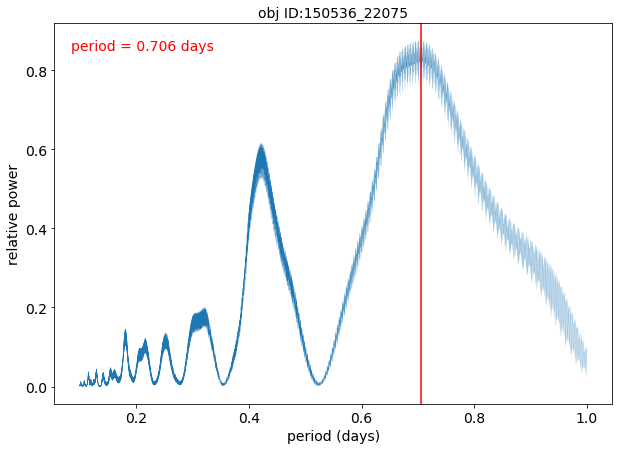

In [6]:
tr,yr,dyr = get_data(star,'r')
tg,yg,dyg = get_data(star,'g')
ti,yi,dyi = get_data(star,'i')

period_r, power_r = get_ls_periodogram(tr,yr)
best_period_r = get_best_period(period_r,power_r)

period_g, power_g = get_ls_periodogram(tg,yg)
best_period_g = get_best_period(period_g,power_g)

period_i, power_i = get_ls_periodogram(ti,yi)
best_period_i = get_best_period(period_i,power_i)

best_period = ( best_period_r + best_period_g + best_period_i ) / 3

plot_periodogram(period_r,power_r,best_period_r,title='obj ID:{}'.format(objname))

vivas_period = 0.658
period = best_period
display(period)

phase_g0 = get_folded_phase(tg,period)
phase_r0 = get_folded_phase(tr,period)
phase_i0 = get_folded_phase(ti,period)

gcrv = np.vstack((tg,yg-min(yg),dyg)).T
rcrv = np.vstack((tr,yr-min(yr),dyr)).T
icrv = np.vstack((ti,yi-min(yi),dyi)).T

In [7]:
gtmps = glob('templets/*g.dat')
gtemplets = np.zeros((len(gtmps),501,2))
for i in range(len(gtmps)):
    gtemplets[i] = np.concatenate((np.array([[0,0]]),
                                   np.array(pd.read_csv(gtmps[i],sep=' ')),
                                   np.array([[1,0]])))

In [8]:
rtmps = glob('templets/*r.dat')
rtemplets = np.zeros((len(rtmps),501,2))
for i in range(len(rtmps)):
    rtemplets[i] = np.concatenate((np.array([[0,0]]),
                                   np.array(pd.read_csv(rtmps[i],sep=' ')),
                                   np.array([[1,0]])))

In [9]:
itmps = glob('templets/*i.dat')
itemplets = np.zeros((len(itmps),501,2))
for i in range(len(itmps)):
    itemplets[i] = np.concatenate((np.array([[0,0]]),
                                   np.array(pd.read_csv(itmps[i],sep=' ')),
                                   np.array([[1,0]])))

In [50]:
class tmpfitter:
    def __init__ (self, tmps):#, tempfltr, fltr):
        self.n=0
        self.tmps=tmps
        #self.tempfltr=tempfltr
        #self.fltr = fltr

    def model(self, t, period, t0, amplitude, yoffset):
        # modify the template using peak-to-peak amplitude, yoffset
        # fold input times t by period, phase shift to match template
        xtemp = self.tmps[self.n,:,0]
        ytemp = self.tmps[self.n,:,1]*amplitude + yoffset
        ph = (t - t0) / period %1
        print((ph[0],period,t0%1))
        #print((period,t0,amplitude,yoffset))
        # interpolate the modified template to the phase we want
        return interp1d(xtemp,ytemp)(ph)

#    def multifiltermodel(self):
#        modelvalues = []# numpy array with same size as datapoints
#        for i in self.tempfltr:
            # Loop over each filter.
            # Get templet for that filter
            # get model datapoints fill in modelvalues
            # np.where(self.fltr)
        # return model values


def tmpfit(tmps,crv,pinit):
    datfit = []
    npars = []
    fitter = tmpfitter(tmps)
    for i in range(len(tmps)):
        fitter.n = i
        pars, cov = curve_fit(fitter.model, crv[:,0], crv[:,1], sigma=crv[:,2], p0=pinit, maxfev=10000)
        datfit.append(median(abs(fitter.model(crv[:,0],pars[0],pars[1],pars[2],pars[3])-crv[:,1])))
        npars.append(pars)
    n = np.argmin(datfit)
    return n, npars[n]

In [51]:
y0=min(gcrv[:,1])
y1=max(gcrv[:,1])
t0=gcrv[np.argmin(gcrv[:,1]),0]
pinit = (period,t0,y1-y0,y0)
gn,gpars = tmpfit(gtemplets,gcrv,pinit)
display(gn)
display(gpars)
#Period, Phase, peak-to-peak Amplitude, yoffset

(0.12220870087578231, 0.7082995979520322, 0.046673096701852046)
(0.12220870087578231, 0.7082995979520322, 0.046673096701852046)
(0.12220870087578231, 0.7082995979520322, 0.046673096701852046)
(0.12220869905473078, 0.7082996085065187, 0.046673096701852046)
(0.1210071813223961, 0.7082995979520322, 0.047524132518447004)
(0.12220870087578231, 0.7082995979520322, 0.046673096701852046)
(0.12220870087578231, 0.7082995979520322, 0.046673096701852046)
(0.13293825262192688, 0.7083147231130827, 0.03907134880137164)
(0.13293825064099257, 0.7083147336677946, 0.03907134880137164)
(0.13173675888981964, 0.7083147231130827, 0.03992238450155128)
(0.13293825262192688, 0.7083147231130827, 0.03907134880137164)
(0.13293825262192688, 0.7083147231130827, 0.03907134880137164)
(0.13623869631018912, 0.7083228315164498, 0.036732491265865974)
(0.13623869428007437, 0.7083228420712825, 0.036732491265865974)
(0.1350372163833345, 0.7083228315164498, 0.03758352692966582)
(0.13623869631018912, 0.7083228315164498, 0.0367

14

array([7.08411117e-01, 5.71119713e+04, 4.51477856e-01, 9.86366779e-04])

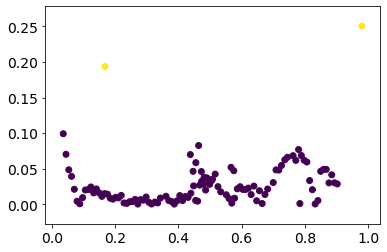

In [12]:
f = interp1d(gtemplets[gn,:,0],gtemplets[gn,:,1]*gpars[2]+gpars[3])
phase_g = (gcrv[:,0]-gpars[1])/gpars[0]%1
dif_g = abs(gcrv[:,1]-f(phase_g))
plt.scatter(phase_g,dif_g,c=dif_g>utils.mad(dif_g)*5)

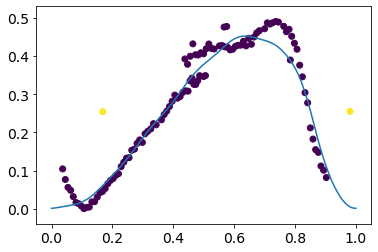

In [13]:
plt.scatter(phase_g,gcrv[:,1],c=dif_g>utils.mad(dif_g)*5)
plt.plot(gtemplets[gn,:,0],gtemplets[gn,:,1]*gpars[2]+gpars[3])

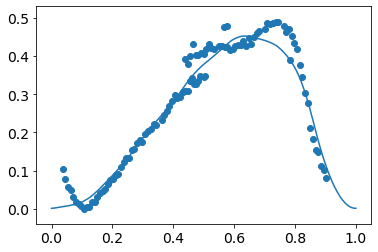

In [14]:
gcrv_in = gcrv[dif_g<utils.mad(dif_g)*5]
phase_g_in = phase_g[dif_g<utils.mad(dif_g)*5]
plt.scatter(phase_g_in,gcrv_in[:,1])
plt.plot(gtemplets[gn,:,0],gtemplets[gn,:,1]*gpars[2]+gpars[3])

In [15]:
gn_in,gpars_in = tmpfit(gtemplets,gcrv_in,gpars)
print('Old:')
display(gn)
display(gpars)
print('New:')
display(gn_in)
display(gpars_in)
#Period, Phase, peak-to-peak Amplitude, yoffset

Old:


14

array([7.08411117e-01, 5.71119713e+04, 4.51477856e-01, 9.86366779e-04])

New:


14

array([ 7.08410814e-01,  5.71119712e+04,  4.61086025e-01, -6.33867106e-03])

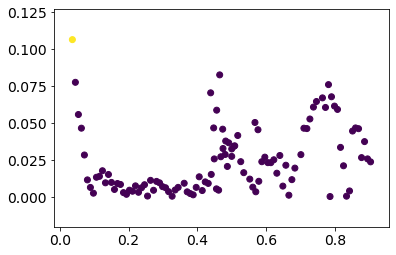

In [16]:
f = interp1d(gtemplets[gn_in,:,0],gtemplets[gn_in,:,1]*gpars_in[2]+gpars_in[3])
phase_g = (gcrv_in[:,0]-gpars_in[1])/gpars_in[0]%1
dif_g_in = abs(gcrv_in[:,1]-f(phase_g_in))
plt.scatter(phase_g,dif_g_in,c=dif_g_in>utils.mad(dif_g_in)*5)

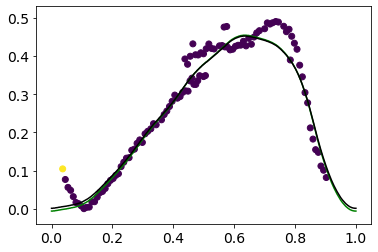

In [17]:
plt.scatter(phase_g_in,gcrv_in[:,1],c=dif_g_in>utils.mad(dif_g_in)*5)
plt.plot(gtemplets[gn_in,:,0],gtemplets[gn_in,:,1]*gpars_in[2]+gpars_in[3],c='g')
plt.plot(gtemplets[gn,:,0],gtemplets[gn,:,1]*gpars[2]+gpars[3],c='black')

In [18]:
y0=min(rcrv[:,1])
y1=max(rcrv[:,1])
t0=rcrv[np.argmin(rcrv[:,1]),0]
pinit = (period,t0,y1-y0,y0)
rn,rpars = tmpfit(rtemplets,rcrv,pinit)
display(rn)
display(rpars)
#Period, Phase, peak-to-peak Amplitude, yoffset

13

array([7.08373481e-01, 5.71120283e+04, 2.95007158e-01, 1.98742923e-03])

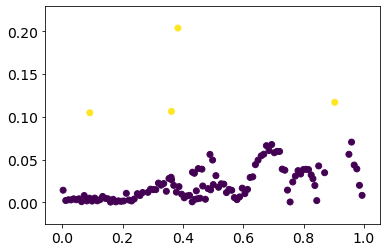

In [19]:
f = interp1d(rtemplets[rn,:,0],rtemplets[rn,:,1]*rpars[2]+rpars[3])
phase_r = (rcrv[:,0]-rpars[1])/rpars[0]%1
dif_r = abs(rcrv[:,1]-f(phase_r))
plt.scatter(phase_r,dif_r,c=dif_r>utils.mad(dif_r)*5)

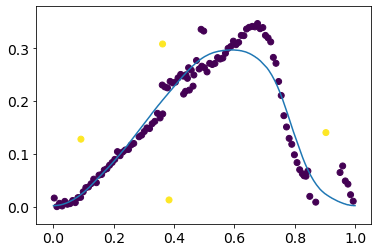

In [20]:
plt.scatter(phase_r,rcrv[:,1],c=dif_r>utils.mad(dif_r)*5)
plt.plot(rtemplets[rn,:,0],rtemplets[rn,:,1]*rpars[2]+rpars[3])

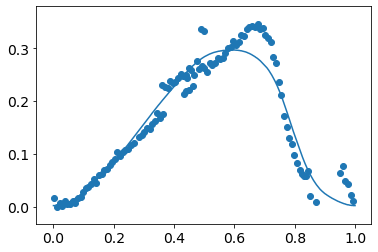

In [21]:
rcrv_in = rcrv[dif_r<utils.mad(dif_r)*5]
phase_r_in = phase_r[dif_r<utils.mad(dif_r)*5]
plt.scatter(phase_r_in,rcrv_in[:,1])
plt.plot(rtemplets[rn,:,0],rtemplets[rn,:,1]*rpars[2]+rpars[3])

In [22]:
rn_in,rpars_in = tmpfit(rtemplets,rcrv_in,rpars)
print('Old:')
display(rn)
display(rpars)
print('New:')
display(rn_in)
display(rpars_in)
#Period, Phase, peak-to-peak Amplitude, yoffset

Old:


13

array([7.08373481e-01, 5.71120283e+04, 2.95007158e-01, 1.98742923e-03])

New:


14

array([6.63164567e-01, 5.71120644e+04, 3.39351230e-01, 2.38345096e-03])

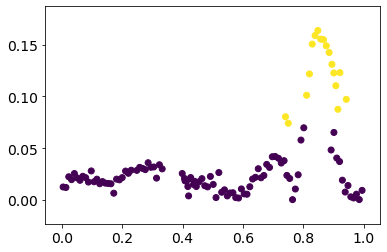

In [23]:
f = interp1d(rtemplets[rn_in,:,0],rtemplets[rn_in,:,1]*rpars_in[2]+rpars_in[3])
phase_r = (rcrv_in[:,0]-rpars_in[1])/rpars_in[0]%1
dif_r_in = abs(rcrv_in[:,1]-f(phase_r_in))
plt.scatter(phase_r,dif_r_in,c=dif_r_in>utils.mad(dif_r_in)*5)

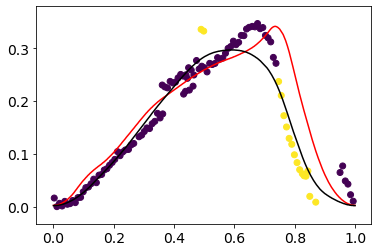

In [24]:
plt.scatter(phase_r_in,rcrv_in[:,1],c=dif_r_in>utils.mad(dif_r_in)*5)
plt.plot(rtemplets[rn_in,:,0],rtemplets[rn_in,:,1]*rpars_in[2]+rpars_in[3],c='r')
plt.plot(rtemplets[rn,:,0],rtemplets[rn,:,1]*rpars[2]+rpars[3],c='black')

In [25]:
y0=min(icrv[:,1])
y1=max(icrv[:,1])
t0=icrv[np.argmin(icrv[:,1]),0]
pinit = (period,t0,y1-y0,y0)
ni,ipars = tmpfit(itemplets,icrv,pinit)
display(ni)
display(ipars)
#Period, Phase, peak-to-peak Amplitude, yoffset

11

array([ 7.08571274e-01,  5.78762709e+04, -2.16545375e-01,  2.83066322e-01])

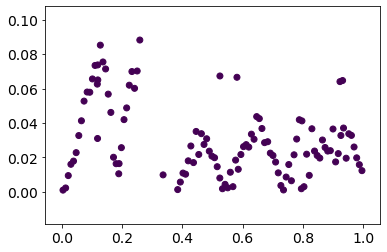

In [26]:
f = interp1d(itemplets[ni,:,0],itemplets[ni,:,1]*ipars[2]+ipars[3])
phase_i = (icrv[:,0]-ipars[1])/ipars[0]%1
dif_i = abs(icrv[:,1]-f(phase_i))
plt.scatter(phase_i,dif_i,c=dif_i>utils.mad(dif_i)*5)

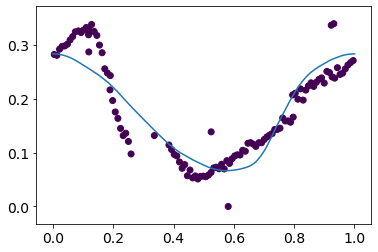

In [27]:
plt.scatter(phase_i,icrv[:,1],c=dif_i>utils.mad(dif_i)*5)
plt.plot(itemplets[ni,:,0],itemplets[ni,:,1]*ipars[2]+ipars[3])

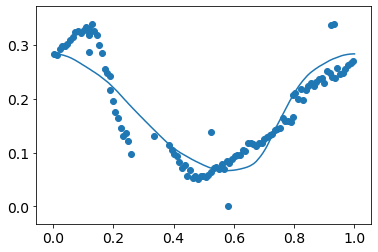

In [28]:
icrv_in = icrv[dif_i<utils.mad(dif_i)*5]
phase_i_in = phase_i[dif_i<utils.mad(dif_i)*5]
plt.scatter(phase_i_in,icrv_in[:,1])
plt.plot(itemplets[ni,:,0],itemplets[ni,:,1]*ipars[2]+ipars[3])

In [29]:
ni_in,ipars_in = tmpfit(itemplets,icrv_in,ipars)
print('Old:')
display(ni)
display(ipars)
print('New:')
display(ni_in)
display(ipars_in)
#Period, Phase, peak-to-peak Amplitude, yoffset

Old:


11

array([ 7.08571274e-01,  5.78762709e+04, -2.16545375e-01,  2.83066322e-01])

New:


11

array([ 7.08571274e-01,  5.78762709e+04, -2.16545375e-01,  2.83066322e-01])

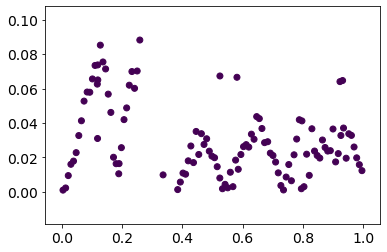

In [30]:
f = interp1d(itemplets[ni_in,:,0],itemplets[ni_in,:,1]*ipars_in[2]+ipars_in[3])
phase_i = (icrv_in[:,0]-ipars_in[1])/ipars_in[0]%1
dif_i_in = abs(icrv_in[:,1]-f(phase_i_in))
plt.scatter(phase_i,dif_i_in,c=dif_i_in>utils.mad(dif_i_in)*5)

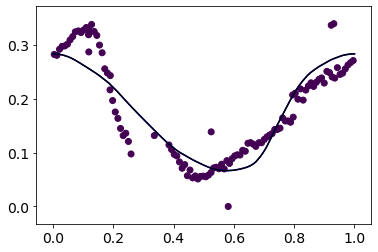

In [31]:
plt.scatter(phase_i_in,icrv_in[:,1],c=dif_i_in>utils.mad(dif_i_in)*5)
plt.plot(itemplets[ni_in,:,0],itemplets[ni_in,:,1]*ipars_in[2]+ipars_in[3],c='b')
plt.plot(itemplets[ni,:,0],itemplets[ni,:,1]*ipars[2]+ipars[3],c='black')

In [32]:
period

0.7082995979520322

In [33]:
period2 = (gpars[0]+rpars[0]+ipars[0])/3
period2

0.7084519572495808

In [34]:
gcrv2 = gcrv.copy()
rcrv2 = rcrv.copy()
icrv2 = icrv.copy()

gcrv2[:,0] = (gcrv2[:,0]-gpars[1])/gpars[0]%1
gcrv2 = np.tile(gcrv2.T,2).T
gcrv2[int(len(gcrv2)/2):,0] += 1
gcrv2 = gcrv2[gcrv2[:,0].argsort()]

rcrv2[:,0] = (rcrv2[:,0]-rpars[1])/rpars[0]%1
rcrv2 = np.tile(rcrv2.T,2).T
rcrv2[int(len(rcrv2)/2):,0] += 1
rcrv2 = rcrv2[rcrv2[:,0].argsort()]

icrv2[:,0] = (icrv2[:,0]-ipars[1])/ipars[0]%1
icrv2 = np.tile(icrv2.T,2).T
icrv2[int(len(icrv2)/2):,0] += 1
icrv2 = icrv2[icrv2[:,0].argsort()]

gtemplets2 = np.tile(gtemplets,(2,1))
gtemplets2[:,int(len(gtemplets2[0])/2):,0] += 1
rtemplets2 = np.tile(rtemplets,(2,1))
rtemplets2[:,int(len(rtemplets2[0])/2):,0] += 1
itemplets2 = np.tile(itemplets,(2,1))
itemplets2[:,int(len(itemplets2[0])/2):,0] += 1


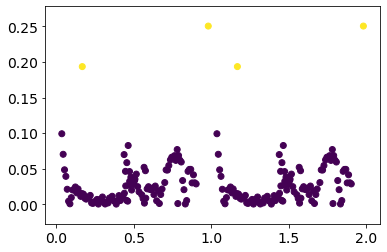

In [35]:
f = interp1d(gtemplets2[gn,:,0],gtemplets2[gn,:,1]*gpars[2]+gpars[3])
difg = abs(gcrv2[:,1]-f(gcrv2[:,0]))
plt.scatter(gcrv2[:,0],difg,c=difg>utils.mad(difg)*5)

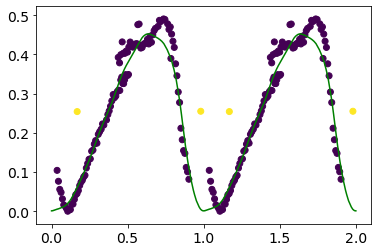

In [36]:
plt.plot(gtemplets2[gn,:,0],gtemplets2[gn,:,1]*gpars[2]+gpars[3],c='g')
plt.scatter(gcrv2[:,0],gcrv2[:,1],c=difg>utils.mad(difg)*5)

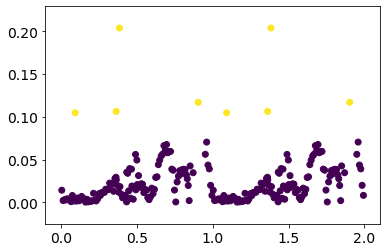

In [37]:
f = interp1d(rtemplets2[rn,:,0],rtemplets2[rn,:,1]*rpars[2]+rpars[3])
difr = abs(rcrv2[:,1]-f(rcrv2[:,0]))
plt.scatter(rcrv2[:,0],difr,c=difr>utils.mad(difr)*5)

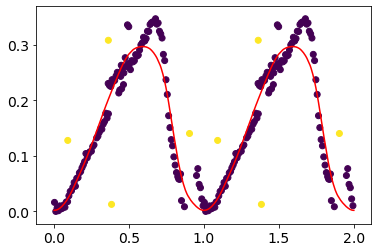

In [38]:
plt.plot(rtemplets2[rn,:,0],rtemplets2[rn,:,1]*rpars[2]+rpars[3],c='r')
plt.scatter(rcrv2[:,0],rcrv2[:,1],c=difr>utils.mad(difr)*5)

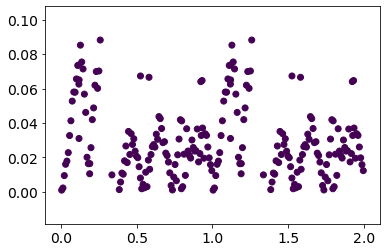

In [39]:
f = interp1d(itemplets2[ni,:,0],itemplets2[ni,:,1]*ipars[2]+ipars[3])
difi = abs(icrv2[:,1]-f(icrv2[:,0]))
plt.scatter(icrv2[:,0],difi,c=difi>utils.mad(difi)*5)

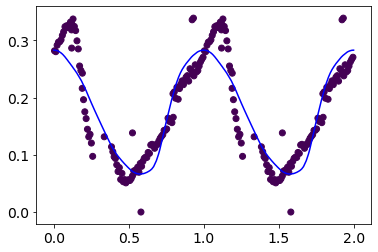

In [40]:
plt.plot(itemplets2[ni,:,0],itemplets2[ni,:,1]*ipars[2]+ipars[3],c='b')
plt.scatter(icrv2[:,0],icrv2[:,1],c=difi>utils.mad(difi)*5)

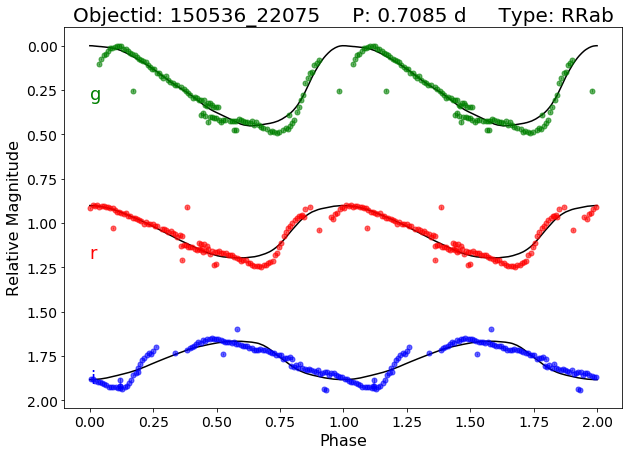

In [41]:
fig, ax = plt.subplots(figsize=(10,7))

gshft = 0
rshft = .9
ishft = 1.6

ax.plot(gtemplets2[gn,:,0],gtemplets2[gn,:,1]*gpars[2] + gpars[3]+gshft,c='black')
ax.plot(rtemplets2[rn,:,0],rtemplets2[rn,:,1]*rpars[2] + rpars[3]+rshft,c='black')
ax.plot(itemplets2[ni,:,0],itemplets2[ni,:,1]*ipars[2] + ipars[3]+ishft,c='black')

ax.errorbar(gcrv2[:,0],gcrv2[:,1]+gshft,yerr=gcrv2[:,2],marker='.',ms=10,ls='none',lw=1,color='g',alpha=.6)
ax.errorbar(rcrv2[:,0],rcrv2[:,1]+rshft,yerr=rcrv2[:,2],marker='.',ms=10,ls='none',lw=1,color='r',alpha=.6)
ax.errorbar(icrv2[:,0],icrv2[:,1]+ishft,yerr=icrv2[:,2],marker='.',ms=10,ls='none',lw=1,color='b',alpha=.6)

ax.text(0,gshft+.3,'g',fontsize=18,color='g')
ax.text(0,rshft+.3,'r',fontsize=18,color='r')
ax.text(0,ishft+.3,'i',fontsize=18,color='b')

ax.set_title('Objectid: {}     P: {:.4f} d     Type: RRab'.format(objname,period2), fontsize=20)
ax.invert_yaxis()
ax.set_xlabel('Phase', fontsize=16)
ax.set_ylabel('Relative Magnitude', fontsize=16);

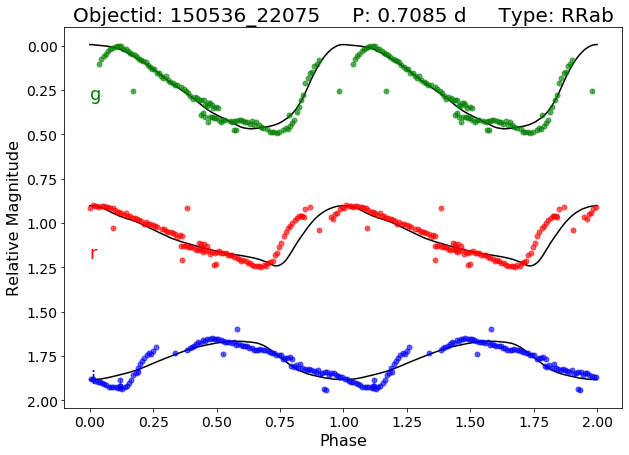

In [42]:
fig, ax = plt.subplots(figsize=(10,7))

gshft = 0
rshft = .9
ishft = 1.6

ax.plot(gtemplets2[gn_in,:,0],gtemplets2[gn_in,:,1]*gpars_in[2]*1.03 + gpars_in[3]+gshft,c='black')
ax.plot(rtemplets2[rn_in,:,0],rtemplets2[rn_in,:,1]*rpars_in[2] + rpars_in[3]+rshft,c='black')
ax.plot(itemplets2[ni_in,:,0],itemplets2[ni_in,:,1]*ipars_in[2] + ipars_in[3]+ishft,c='black')

ax.errorbar(gcrv2[:,0],gcrv2[:,1]+gshft,yerr=gcrv2[:,2],marker='.',ms=10,ls='none',lw=1,color='g',alpha=.6)
ax.errorbar(rcrv2[:,0],rcrv2[:,1]+rshft,yerr=rcrv2[:,2],marker='.',ms=10,ls='none',lw=1,color='r',alpha=.6)
ax.errorbar(icrv2[:,0],icrv2[:,1]+ishft,yerr=icrv2[:,2],marker='.',ms=10,ls='none',lw=1,color='b',alpha=.6)

ax.text(0,gshft+.3,'g',fontsize=18,color='g')
ax.text(0,rshft+.3,'r',fontsize=18,color='r')
ax.text(0,ishft+.3,'i',fontsize=18,color='b')

ax.set_title('Objectid: {}     P: {:.4f} d     Type: RRab'.format(objname,period2), fontsize=20)
ax.invert_yaxis() 
ax.set_xlabel('Phase', fontsize=16)
ax.set_ylabel('Relative Magnitude', fontsize=16);